In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/../src/simulations_v2")
    sys.path.append(module_path + "/..")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *

In [3]:
centre_point = get_centre_point()
lhs_output_sim_files = []
for i in range(2000):
    fname = '/home/aaj54/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)
scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)

In [4]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    sim_dfs = list()
    for group in sim.sims:
        df = group.sim_df
        sim_dfs.append(df)
    return sim_dfs

def run_multiple_trajectories(sim, T, n):
    sim_df_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        sim_df_matrix.append(result)
    return sim_df_matrix

def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)

    group_size = list()
    tests_per_day = 0

    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]

    assert len(group_size) == len(test_frac)

    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    sim_df_matrix = run_multiple_trajectories(sim, T, n)
    return sim_df_matrix

In [7]:
centre_params_list, centre_matrix, centre_names = uncertainty_point_to_params_dict(centre_point)[0]
pess_params_list, pess_matrix, pess_names = uncertainty_point_to_params_dict(res_pessimistic)[0]

In [26]:
centre_sim_matrix = evaluate_testing_policy(centre_params_list, centre_matrix, centre_names, [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0], 112, 15)
pess_sim_matrix = evaluate_testing_policy(pess_params_list, pess_matrix, pess_names, [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0], 112, 15)

In [27]:
centre_trajs = list()
for traj in centre_sim_matrix:
#     print(np.array(get_cum_inf_trajectory(traj[0])) + np.array(get_cum_inf_trajectory(traj[1])))
#     print(np.sum([np.array(get_cum_inf_trajectory(traj[0])), np.array(get_cum_inf_trajectory(traj[1]))], axis=0))
    centre_trajs.append(np.sum([np.array(get_cum_inf_trajectory(df)) for df in traj], axis=0))
    
pess_trajs = list()
for traj in pess_sim_matrix:
    pess_trajs.append(np.sum([np.array(get_cum_inf_trajectory(df)) for df in traj], axis=0))

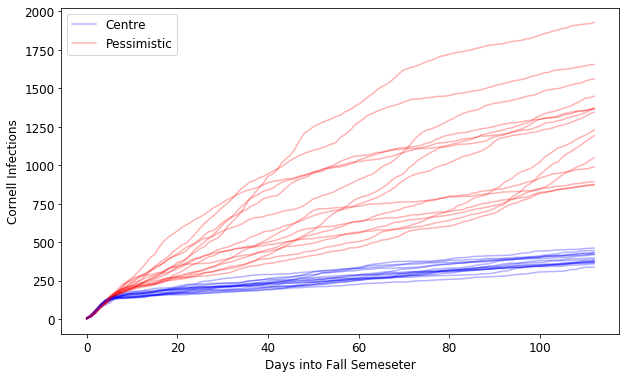

In [28]:
plt.figure(figsize=(10,6))
label = True
for centre_traj, pess_traj in zip(centre_trajs, pess_trajs):
    if label:
        plt.plot(centre_traj, color='blue', alpha=0.3, label='Centre')
        plt.plot(pess_traj, color='red', alpha=0.3, label='Pessimistic')
        label = False
    else:
        plt.plot(centre_traj, color='blue', alpha=0.3)
        plt.plot(pess_traj, color='red', alpha=0.3)

plt.legend()
plt.xlabel('Days into Fall Semeseter')
plt.ylabel('Cornell Infections')
plt.show()

In [11]:
centre_trajs

[29053.0,
 32102.0,
 28074.0,
 30572.0,
 27965.0,
 30442.0,
 34071.0,
 31516.0,
 30470.0,
 25738.0,
 28923.0,
 29429.0,
 29055.0,
 31078.0,
 28948.0]